## Сonvolutional Neural Network

In [1]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils
#набор данных
from keras.datasets import cifar10

## Загружаем данные

In [2]:
seed = 21

# загружаем данные
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

## Подготовка данные

In [3]:
# нормализуем входные данные от 0-255 до от 0 до 1 путем деления на 255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [4]:
# унитарное кодирование, так как явное изображение сетью не воспринимаетя
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
class_num = y_test.shape[1]

## Создание модели

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))

In [6]:
#исключающий слой для предотвращения переобучения, который случайным образом устраняет соединения 
#между слоями (0,2 означает, что он отбрасывает 20% существующих соединений):
model.add(Dropout(0.2))

In [7]:
#Пакетная нормализация нормализует входные данные, поступающие в следующий слой, гарантируя, что сеть всегда создает функции 
#активации с тем же распределением, которое нам нужно
model.add(BatchNormalization())


In [8]:
# размер фильтра увеличивается, так что сеть уже может изучать более сложные представления
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

Это основа рабочего процесса в первой части реализации CNN: свертка, активация, исключение, объединение

In [9]:
#повторили эти слои, чтобы дать сети больше представлений для работы
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

In [10]:
#нужно сжать данные
model.add(Flatten())
model.add(Dropout(0.2))

In [11]:
#создаем первый плотно связанный слой
model.add(Dense(256, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(128, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

In [12]:
#функция активации softmax выбирает нейрон с наибольшей вероятностью в качестве своего выходного значения, 
#предполагая, что изображение принадлежит именно этому классу
model.add(Dense(class_num))
model.add(Activation('softmax'))

Оптимизатор - это то, что настроит веса в вашей сети так, чтобы приблизиться к точке с наименьшими потерями. Алгоритм Адама является одним из наиболее часто используемых оптимизаторов, потому что он дает высокую производительность в большинстве задач

In [13]:
optimizer = 'adam'

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [15]:
#сводку по модели, чтобы получить представление о модели в целом
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0

**Обучение модели**

Возьмём тренировочный набор в 50000 образцов и проверочный в 10000 образцов.



In [16]:
numpy.random.seed(seed)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
782/782 [==============================] - 256s 328ms/step - loss: 1.4957 - accuracy: 0.4681 - val_loss: 1.1786 - val_accuracy: 0.5812
Epoch 2/5
782/782 [==============================] - 256s 328ms/step - loss: 1.0493 - accuracy: 0.6261 - val_loss: 0.8428 - val_accuracy: 0.6959
Epoch 3/5
782/782 [==============================] - 257s 329ms/step - loss: 0.8586 - accuracy: 0.6969 - val_loss: 0.7528 - val_accuracy: 0.7316
Epoch 4/5
782/782 [==============================] - 255s 327ms/step - loss: 0.7653 - accuracy: 0.7324 - val_loss: 0.7200 - val_accuracy: 0.7487
Epoch 5/5
782/782 [==============================] - 259s 332ms/step - loss: 0.7057 - accuracy: 0.7537 - val_loss: 0.6733 - val_accuracy: 0.7636


In [17]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 76.36%


## Визуализация

In [18]:
import matplotlib.pyplot as plt

In [22]:
X_train.shape


(50000, 32, 32, 3)

In [23]:
X_test.shape

(10000, 32, 32, 3)

In [47]:
#Добавим слой Пулинг по Максимуму, и запустим на 10 эпох. Так же поменяем функцию ошибки и оптимизации.
# создание модели
model2 = Sequential()
model2.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(10, activation='softmax'))
model2.compile(optimizer='sgd', loss='mean_squared_error', metrics=['accuracy'])


In [48]:
history = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15)

Epoch 1/15
1563/1563 [==============================] - 283s 181ms/step - loss: 0.0791 - accuracy: 0.3380 - val_loss: 0.0687 - val_accuracy: 0.4635
Epoch 2/15
1563/1563 [==============================] - 307s 196ms/step - loss: 0.0687 - accuracy: 0.4552 - val_loss: 0.0638 - val_accuracy: 0.5073
Epoch 3/15
1563/1563 [==============================] - 297s 190ms/step - loss: 0.0635 - accuracy: 0.5063 - val_loss: 0.0597 - val_accuracy: 0.5453
Epoch 4/15
1563/1563 [==============================] - 290s 185ms/step - loss: 0.0595 - accuracy: 0.5449 - val_loss: 0.0568 - val_accuracy: 0.5763
Epoch 5/15
1563/1563 [==============================] - 289s 185ms/step - loss: 0.0562 - accuracy: 0.5752 - val_loss: 0.0543 - val_accuracy: 0.5918
Epoch 6/15
1563/1563 [==============================] - 289s 185ms/step - loss: 0.0537 - accuracy: 0.5961 - val_loss: 0.0535 - val_accuracy: 0.5964
Epoch 7/15
1563/1563 [==============================] - 297s 190ms/step - loss: 0.0514 - accuracy: 0.6158 - val_

In [49]:
scores = model2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 66.33%


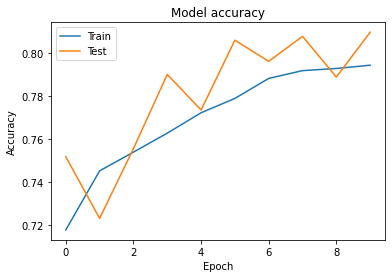

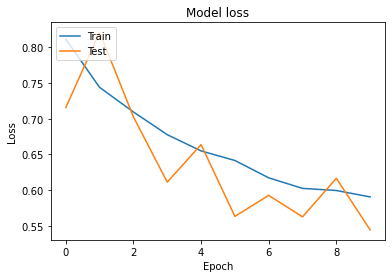

In [26]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
print(hist.history)

{'loss': [0.8114484548568726, 0.7438879013061523, 0.7094597816467285, 0.6776170134544373, 0.6548497080802917, 0.6414543986320496, 0.617153525352478, 0.6023409366607666, 0.5993691682815552, 0.5903852581977844], 'accuracy': [0.717739999294281, 0.7451599836349487, 0.7538400292396545, 0.762660026550293, 0.7721199989318848, 0.7787799835205078, 0.7880600094795227, 0.7916799783706665, 0.792680025100708, 0.7942000031471252], 'val_loss': [0.715582549571991, 0.8211833834648132, 0.7025038003921509, 0.6111146807670593, 0.6637380123138428, 0.5631264448165894, 0.5925504565238953, 0.562441349029541, 0.616459310054779, 0.5441374778747559], 'val_accuracy': [0.7516999840736389, 0.7231000065803528, 0.7555000185966492, 0.789900004863739, 0.7734000086784363, 0.8058000206947327, 0.7960000038146973, 0.8076000213623047, 0.7886999845504761, 0.809499979019165]}


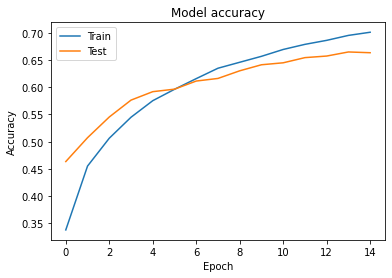

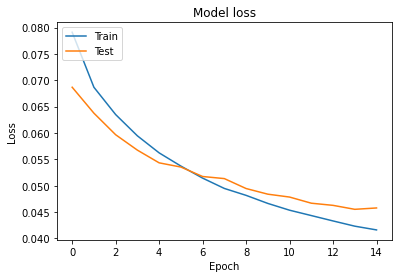

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()